# Description

Seek to find the largest value of k up to which linear theory gives accurate results. Such value for kmax is found for each density bin separately. We use Markov Chain Monte Carlo to fit $b1$ and $\beta$. To assert if linear theory is accurate, we compare the inferred $f_0*\sigma_8$ to the true one.

The fitting process is layed out in `Fit_b1_beta_MCMC.ipynb`. Here we use the mock covariance matrix.

For the simple model at hand, the multipoles can be computed analytically via
$$
P_{\ell}(k) = \int_{-1}^{1} \frac{2\ell+1}{2} L_{\ell}(\mu) P^{model}(k,\mu) d\mu, \quad P^{model}(k,\mu) = (1+\beta \mu^2)^2b_1^2P^{matter}_{lin}(k) \exp{(-\frac{1}{2}(\sigma k \mu)^2)}.
$$
where $P^{model}(k,\mu)$ denotes the redshift space power spectrum.

The simplest model is the linear Kaiser law: $P^{model}(k,\mu) = (1+\beta \mu^2)^2b_1^2P^{matter}_{lin}(k)$, leading to:
$$
\begin{align}
    P_0(k) = (1 + \frac{2}{3}\beta + \frac{1}{5}\beta^2 ) b_1^2 P_{lin}(k) \\
    P_2(k) = (\frac{4}{3}\beta + \frac{4}{7}\beta^2) b_1^2 P_{lin}(k).
\end{align}
$$
When including a FoG term:
$$
\begin{align}
    P_0(k) = \frac{1}{2 k^5 \sigma ^5} \left(\sqrt{2 \pi } \text{erf}\left(\frac{k \sigma }{\sqrt{2}}\right) \left(3 \beta ^2+k^4 \sigma ^4+2 \beta  k^2 \sigma ^2\right)+e^{-\frac{1}{2} k^2 \sigma ^2} \left(-2 \beta  (\beta +2) k^3 \sigma ^3-6 \beta ^2 k \sigma \right)\right) b_1^2 P_{lin}(k) \\
    P_2(k) = -\frac{5}{4 k^7 \sigma ^7} \left(\sqrt{2 \pi } \text{erf}\left(\frac{k \sigma }{\sqrt{2}}\right) \left(-45 \beta ^2+k^6 \sigma ^6+(2 \beta -3) k^4 \sigma ^4+3 (\beta -6) \beta  k^2 \sigma ^2\right) \\
    +e^{-\frac{1}{2} k^2 \sigma ^2}\left(2 (2 \beta  (\beta +2)+3) k^5 \sigma ^5+12 \beta  (2 \beta +3) k^3 \sigma ^3+90 \beta ^2 k \sigma \right) \right) b_1^2 P_{lin}.
\end{align}
$$



In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import legendre, erf
from datetime import timedelta
import time

import inv_cov_funcs as icf
import cat_power_algos as catpk
import classylss
import fitsio
import zeus 
from nbodykit.lab import *
from nbodykit import style
plt.style.use(style.notebook)

In [3]:
LOS = [0,0,1]
redshift = 0
BoxSize = 2000
cosmo_paras = classylss.load_ini('/home/jwack/main/Planck18_LCDM.ini')
cosmo = cosmology.cosmology.Cosmology.from_dict(cosmo_paras)
Plin = cosmology.LinearPower(cosmo, redshift, transfer='CLASS')
sigma8_lin = Plin.sigma8
sigma8_true = 0.8111 
f0_true = cosmo.scale_independent_growth_rate(redshift)

dk = 0.01
ells = [0,2]
damped = True # choice of model

/home/jwack/.conda/envs/nbodykit-env/lib/python3.8/site-packages/nbodykit/cosmology/cosmology.py:427: UserWarning: Class did not read input parameter(s): sigma_8
  self.engine = ClassEngine(pars)


In [5]:
# load computed power spectra to deduce multipoles in each bin and P(k,mu) from data
k_full, shotnoise, n_ptile, Pk_ells_full = icf.load_power_data('/home/jwack/main/fitmodel_densitysplit/', 
                                                               ells, get_data_Pkmus=False)
# for given BoxSize, k is NaN above 0.034
possible_kmax = k_full[k_full<=0.343][1:] # ignore first k bin 

In [6]:
# Maximum entropy priors

# def logprior(theta, mean_guess, damped):
#     ''' The natural logarithm of the prior probability. From pre-analysis step obtained an estimate of the parameter mean values
#     s.t. the maximum entropy prior is the exponential distribution. No value could be estimated for FoG parameter, hence
#     uniform prior.
#     Assume parameters independent such that log priors add. When damped is True, also fit FoG parameter.
#     Note that normalization is irrelevant for MCMC.'''
#     lp = 0.
#     b1_mean, beta_mean = mean_guess
#     if damped:
#         b1, beta, sigma = theta
#         sigma_min, sigma_max = 1, 5
#         lp_sigma = 0. if sigma_min < sigma < sigma_max else -np.inf
#     else:
#         b1, beta = theta
#         lp_sigma = 0
        
#     lp_b1 = -b1/np.abs(b1_mean) if b1 > 0 else -np.inf
#     if beta_mean > 0:
#         lp_beta = -beta/beta_mean if beta > 0 else -np.inf
#     else:
#         lp_beta = -beta/beta_mean if beta < 0 else -1e6#-np.inf
        
#     return lp_b1 + lp_beta + lp_sigma

In [7]:
def logprior(theta, i, kmax, damped):
    ''' The natural logarithm of the prior probability. Assume parameters independent such that log priors add.
    When damped is True, also fit FoG parameter
    Note that normalization is irrelevant for MCMC.'''
    lp = 0.
    if damped:
        b1, beta, sigma = theta
        sigma_min, sigma_max = 1, 5
        sigma_max = 5 if kmax < 0.12 else 30
        lp_sigma = 0. if sigma_min < sigma < sigma_max else -np.inf
    else:
        b1, beta = theta
        lp_sigma = 0
        
    b1_min, b1_max = 0, 3
    if i == 0:
        beta_min, beta_max = -3, 3
    else:
        beta_min, beta_max = 0, 3
        
    lp_b1 = 0. if b1_min < b1 < b1_max else -np.inf
    lp_beta = 0. if beta_min < beta < beta_max else -np.inf
    
    return lp_b1 + lp_beta + lp_sigma


def loglike(theta, data_multipoles, k, C_inv, damped):
    '''Return logarithm of likelihood i.e. -0.5*chi2.
    data_multipoles must be an array of shape (len(ells), len(k)). theta is parameter vector: [b1, beta, sigma].'''
    ells = [0,2]
    model_multipoles = np.empty((len(ells), len(k)))

    if damped:
        b1, beta, sigma = theta
        model_multipoles[0] = ( 1/(2*(k*sigma)**5) * (np.sqrt(2*np.pi)*erf(k*sigma/np.sqrt(2))*(3*beta**2+(k*sigma)**4+2*beta*(k*sigma)**2) + 
                                                    np.exp(-0.5*(k*sigma)**2)*(-2*beta*(beta+2)*(k*sigma)**3-6*beta**2*k*sigma) ) ) * b1**2 * Plin(k)
        model_multipoles[1] = ( -5/(4*(k*sigma)**7) * (np.sqrt(2*np.pi)*erf(k*sigma/np.sqrt(2))*(-45*beta**2+(k*sigma)**6+(2*beta-3)*(k*sigma)**4+3*(beta-6)*beta*(k*sigma)**2) + 
                                                    np.exp(-0.5*(k*sigma)**2)*((4*beta*(beta+2)+6)*(k*sigma)**5+12*beta*(2*beta+3)*(k*sigma)**3+90*beta**2*k*sigma) ) ) * b1**2 * Plin(k)
    else:
        b1, beta = theta
        model_multipoles[0] = (1 + 2/3*beta + 1/5*beta**2) * b1**2 * Plin(k)
        model_multipoles[1] = (4/3*beta + 4/7*beta**2) * b1**2 * Plin(k)

    D_M = (data_multipoles - model_multipoles).flatten()
    
    return -0.5*D_M@(C_inv @ D_M)


def logpost(theta, i, data_multipoles, k, C_inv, damped):
    '''Returns the logarithm of the posterior. By Bayes' theorem, this is just the sum of the log prior and log likelihood (up 
    to a irrelavant constant).
    Uses values for theta from pre-analysis step to inform prior
    ''' 
    return logprior(theta, i, k[-1], damped) + loglike(theta, data_multipoles, k, C_inv, damped)

In [8]:
# set range of kmax for which we compute delta_fs8 for each density bin. 
# exclude taking lowested k bin as kmax since that bin will be removed in slicing (negative quadrupole)
kmax_range = possible_kmax[:21]
Nkmax = len(kmax_range)

chains = np.empty((n_ptile, Nkmax), dtype='object')

b1_fits, beta_fits, sigma_fits, delta_fs8 = np.full((n_ptile, Nkmax), np.nan), np.full((n_ptile, Nkmax), np.nan), np.full((n_ptile, Nkmax), np.nan), np.full((n_ptile, Nkmax), np.nan) 
b1_stds, beta_stds, sigma_stds, delta_fs8_stds = np.full((n_ptile, Nkmax), np.nan), np.full((n_ptile, Nkmax), np.nan), np.full((n_ptile, Nkmax), np.nan), np.full((n_ptile, Nkmax), np.nan)
reduced_chi2 = np.full((n_ptile, Nkmax), np.nan)

nsteps = 2500

if damped == True:
    ndim = 3
    nwalkers = 8 
#     b1_guesses = np.loadtxt('fit_prep/b1_guess_damped.txt')
#     beta_guesses = np.loadtxt('fit_prep/beta_guess_damped.txt')
    start_b1 = 0.5 + 1*np.random.random(nwalkers)
    start_beta = 0.5 + 1*np.random.random(nwalkers)
    start_sigma = 1 + 4*np.random.random(nwalkers) 
    start = np.column_stack([start_b1, start_beta, start_sigma])
else:
    ndim = 2
    nwalkers = 6 
#     b1_guesses = np.loadtxt('fit_prep/b1_guess.txt')
#     beta_guesses = np.loadtxt('fit_prep/beta_guess.txt')
    start_b1 = 0.5 + 1*np.random.random(nwalkers)
    start_beta = 0.5 + 1*np.random.random(nwalkers)
    start = np.column_stack([start_b1, start_beta])


print("Fitting up to kmax=%.3f"%kmax_range[-1])

for i in range(n_ptile):
    cov_mat = np.loadtxt('/home/jwack/main/bruteforce_covmat/covariance_matricies/cov_ptile_%d.txt'%i)
    t1 = time.time()
    for j,kmax in enumerate(kmax_range):
        # slice up to increasingly large kmax and find delta_fs8 for each bin
        mask = np.full(len(k_full), False)
        mask = k_full <= kmax
        mask[0] = False 
        k_sliced = k_full[mask]
        Pk_ells_i = Pk_ells_full[:,:,mask][i]
        C_inv = icf.mock_cov_mat_inv(cov_mat, k_full, kmax)
        
#         guesses = [b1_guesses[i][j], beta_guesses[i][j]]
        sampler = zeus.EnsembleSampler(nwalkers, ndim, logpost, maxiter=1e5, verbose=False, args=[i, Pk_ells_i, k_sliced, C_inv, damped]) 
        sampler.run_mcmc(start, nsteps)
        
        chain = sampler.get_chain(flat=True, discard=nsteps//2)
        chains[i][j] = chain # only needed when wanting to investigate chains later on
        
        b1_fits[i][j], b1_stds[i][j] = np.mean(chain[:,0]), np.std(chain[:,0]) 
        # parameter space is sym about b1=0 for Kaiser model. To get non negative fs8 assure that b1 and beta have the same sign
        if i == 0:
            b1_fits[i][j] *= -1
        beta_fits[i][j], beta_stds[i][j] = np.mean(chain[:,1]), np.std(chain[:,1])
        delta_fs8[i][j] = 1 - sigma8_lin*(beta_fits[i][j]*b1_fits[i][j])/(f0_true*sigma8_true)
        delta_fs8_stds[i][j] = np.abs(sigma8_lin/(f0_true*sigma8_true)*(beta_stds[i][j]*b1_fits[i][j]+beta_fits[i][j]*b1_stds[i][j]))        
        if damped:
            sigma_fits[i][j], sigma_stds[i][j] = np.mean(chain[:,2]), np.std(chain[:,2])
            reduced_chi2[i][j] = -2*loglike([b1_fits[i][j], beta_fits[i][j], sigma_fits[i][j]], Pk_ells_i, k_sliced, C_inv, damped) / (len(ells)*len(k_sliced)-ndim)
        else:
            reduced_chi2[i][j] = -2*loglike([b1_fits[i][j], beta_fits[i][j]], Pk_ells_i, k_sliced, C_inv, damped) / (len(ells)*len(k_sliced)-ndim)
            
    t2 = time.time()
    print('Fitted %d-th percentile in %s'%(i,str(timedelta(seconds=t2-t1))))

Fitting up to kmax=0.215


Sampling progress : 100%|███████████████████████████████████████████████████████████| 2500/2500 [00:44<00:00, 56.35it/s]


Fitted 0-th percentile in 0:28:04.804251


Sampling progress : 100%|███████████████████████████████████████████████████████████| 2500/2500 [00:42<00:00, 58.39it/s]


Fitted 1-th percentile in 0:17:55.472689


Sampling progress : 100%|███████████████████████████████████████████████████████████| 2500/2500 [00:56<00:00, 44.51it/s]


Fitted 2-th percentile in 0:19:26.605178


Sampling progress : 100%|███████████████████████████████████████████████████████████| 2500/2500 [00:42<00:00, 58.22it/s]


Fitted 3-th percentile in 0:14:52.737030


Sampling progress : 100%|███████████████████████████████████████████████████████████| 2500/2500 [00:48<00:00, 51.29it/s]


Fitted 4-th percentile in 0:15:45.437257


Sampling progress : 100%|███████████████████████████████████████████████████████████| 2500/2500 [00:47<00:00, 52.85it/s]


Fitted 5-th percentile in 0:15:35.633880


Sampling progress : 100%|███████████████████████████████████████████████████████████| 2500/2500 [00:45<00:00, 55.18it/s]


Fitted 6-th percentile in 0:13:49.664323


Sampling progress : 100%|███████████████████████████████████████████████████████████| 2500/2500 [01:43<00:00, 24.11it/s]


Fitted 7-th percentile in 0:15:38.787604


Sampling progress : 100%|███████████████████████████████████████████████████████████| 2500/2500 [01:34<00:00, 26.49it/s]


Fitted 8-th percentile in 0:15:16.416638


Sampling progress : 100%|███████████████████████████████████████████████████████████| 2500/2500 [01:17<00:00, 32.33it/s]


Fitted 9-th percentile in 0:17:21.133183


In [11]:
# store data
if damped:
    root_path = 'fit_results/FoG_largesigma/'
    np.savetxt(root_path+'sigma_fits.txt', sigma_fits)
    np.savetxt(root_path+'sigma_stds.txt', sigma_stds)
else:
    root_path = 'fit_results/NoFoG/'

np.savetxt(root_path+'b1_fits.txt', b1_fits)
np.savetxt(root_path+'b1_stds.txt', b1_stds)

np.savetxt(root_path+'beta_fits.txt', beta_fits)
np.savetxt(root_path+'beta_stds.txt', beta_stds)

np.savetxt(root_path+'delta_fs8.txt', delta_fs8)
np.savetxt(root_path+'delta_fs8_stds.txt', delta_fs8_stds)

np.savetxt(root_path+'reduced_chi2.txt', reduced_chi2)

Repeat computation for full (not density binned) power spectrum. Since the mock covariance matrix was only computed for individual density bins, we use Gaussian covariance with Pkmu inferred from the data. See eq 24 of Grieb et al. 2016: https://arxiv.org/pdf/1509.04293.pdf.

In [ ]:
full_delta_fs8, full_delta_fs8_stds = np.full(Nkmax, np.nan), np.full(Nkmax, np.nan)

r = FFTPower.load('density_bins/all_bins.json')

for i,kmax in enumerate(kmax_range):
    mask = np.full(len(k_full), False)
    mask = k_full <= kmax
    mask[0] = False 
    k_sliced = k_full[mask]
    
    Pk_0, Pk_2 = r.poles['power_0'].real-r.attrs['shotnoise'], r.poles['power_2'].real
    Pk_ells = np.row_stack([Pk_0, Pk_2])[:,mask]
    mus = r.power.coords['mu']
    Pkmu_data = (np.outer(Pk_0, legendre(0)(mus)) + np.outer(Pk_2, legendre(2)(mus)))[mask]
    
    C_inv = icf.gaussian_cov_mat_inv(k_sliced, ells, BoxSize, r.attrs['shotnoise'], 0.01, Pkmu_data, mus)
    sampler = zeus.EnsembleSampler(nwalkers, ndim, logpost, maxiter=1e5, verbose=False, args=[-1, Pk_ells, k_sliced, C_inv, damped]) 
    sampler.run_mcmc(start, nsteps)

    chain = sampler.get_chain(flat=True, discard=nsteps//2)

    full_delta_fs8[i] = 1 - sigma8_lin*(np.mean(chain[:,1])*np.mean(chain[:,0]))/(f0_true*sigma8_true)
    full_delta_fs8_stds[i] = np.abs(sigma8_lin/(f0_true*sigma8_true)*(np.std(chain[:,1])*np.mean(chain[:,0])+np.mean(chain[:,1])*np.std(chain[:,0])))

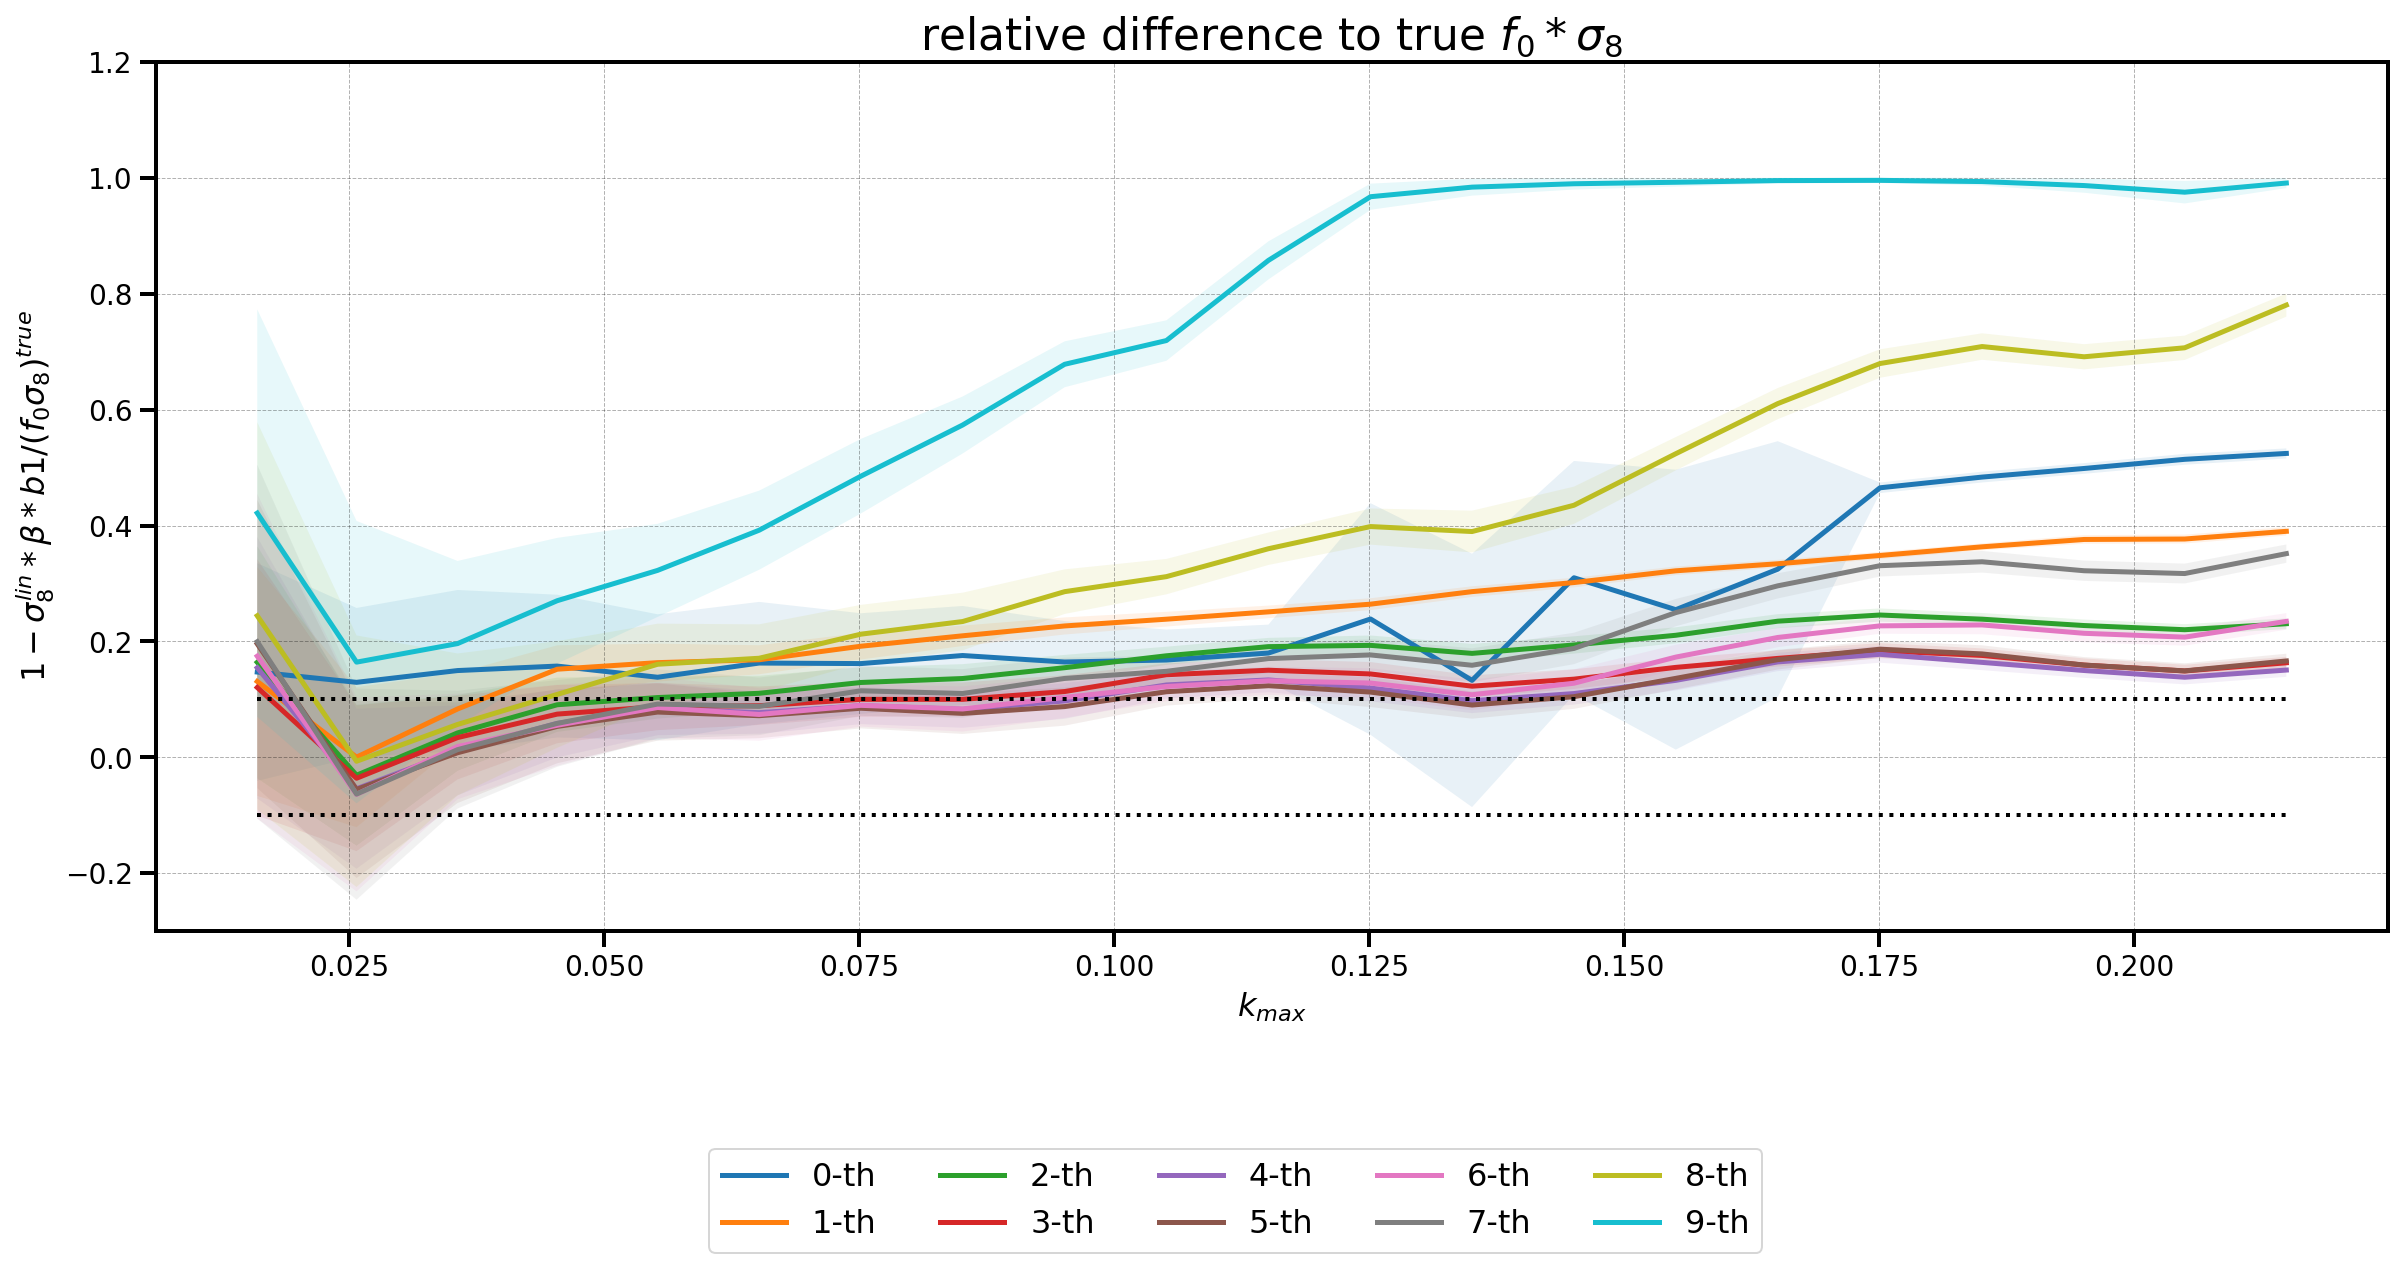

In [14]:
fig = plt.figure(figsize=(20,8))

for i in range(n_ptile):
    plt.plot(kmax_range, delta_fs8[i], label='%d-th'%i)
    plt.fill_between(kmax_range, delta_fs8[i]-delta_fs8_stds[i,:], delta_fs8[i]+delta_fs8_stds[i,:], alpha=0.1)
    
#plt.plot(kmax_range, full_delta_fs8, '--', label='all densities', c='k')
#plt.fill_between(kmax_range, full_delta_fs8-full_delta_fs8_stds, full_delta_fs8+full_delta_fs8_stds, color='k', alpha=0.1)
    
# add 10% diviation lines
plt.hlines([-0.1, 0.1], kmax_range[0], kmax_range[-1], linestyle='dotted', color='k', linewidth=2)

plt.ylim([-0.3, 1.2])

plt.title(r'relative difference to true $f_0*\sigma_8$')
plt.xlabel(r'$k_{max}$')
plt.ylabel(r'$1 - \sigma_8^{lin}*\beta*b1/(f_0\sigma_8)^{true}$')

handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=5)
plt.show()

#fig.savefig("plots/Kaiserdamped_largesig_dfs8_vs_kmax.pdf")

### Interpretation
As observed in previous analysis steps, bins of extreme density are more difficult to fit with such a simple model than the middle density bins. Hence the agreement of fs8 worse for these bins. From a 'by eye' inspection, we find that the 10% accuracy for the middle bins is surpassed at $kmax \approx 0.06$ the latest. When including a FoG term, this threshold is pushed to slightly larger $kmax$. Regardless of the model, fs8 is typically underestimated for all density and bins. 
In the Kaiser+FoG model, density bin 9 produces fs8 $\approx 0$ for $kmax>0.125$. This is due to $\beta$ being fitted close to zero and $b_1$ not being fitted to a large enough value to compensate.

The issue of dealing with negative $\beta$ being fitted for the lowest density bin is described in `Fit_b1_beta_MCMC.ipynb`. 

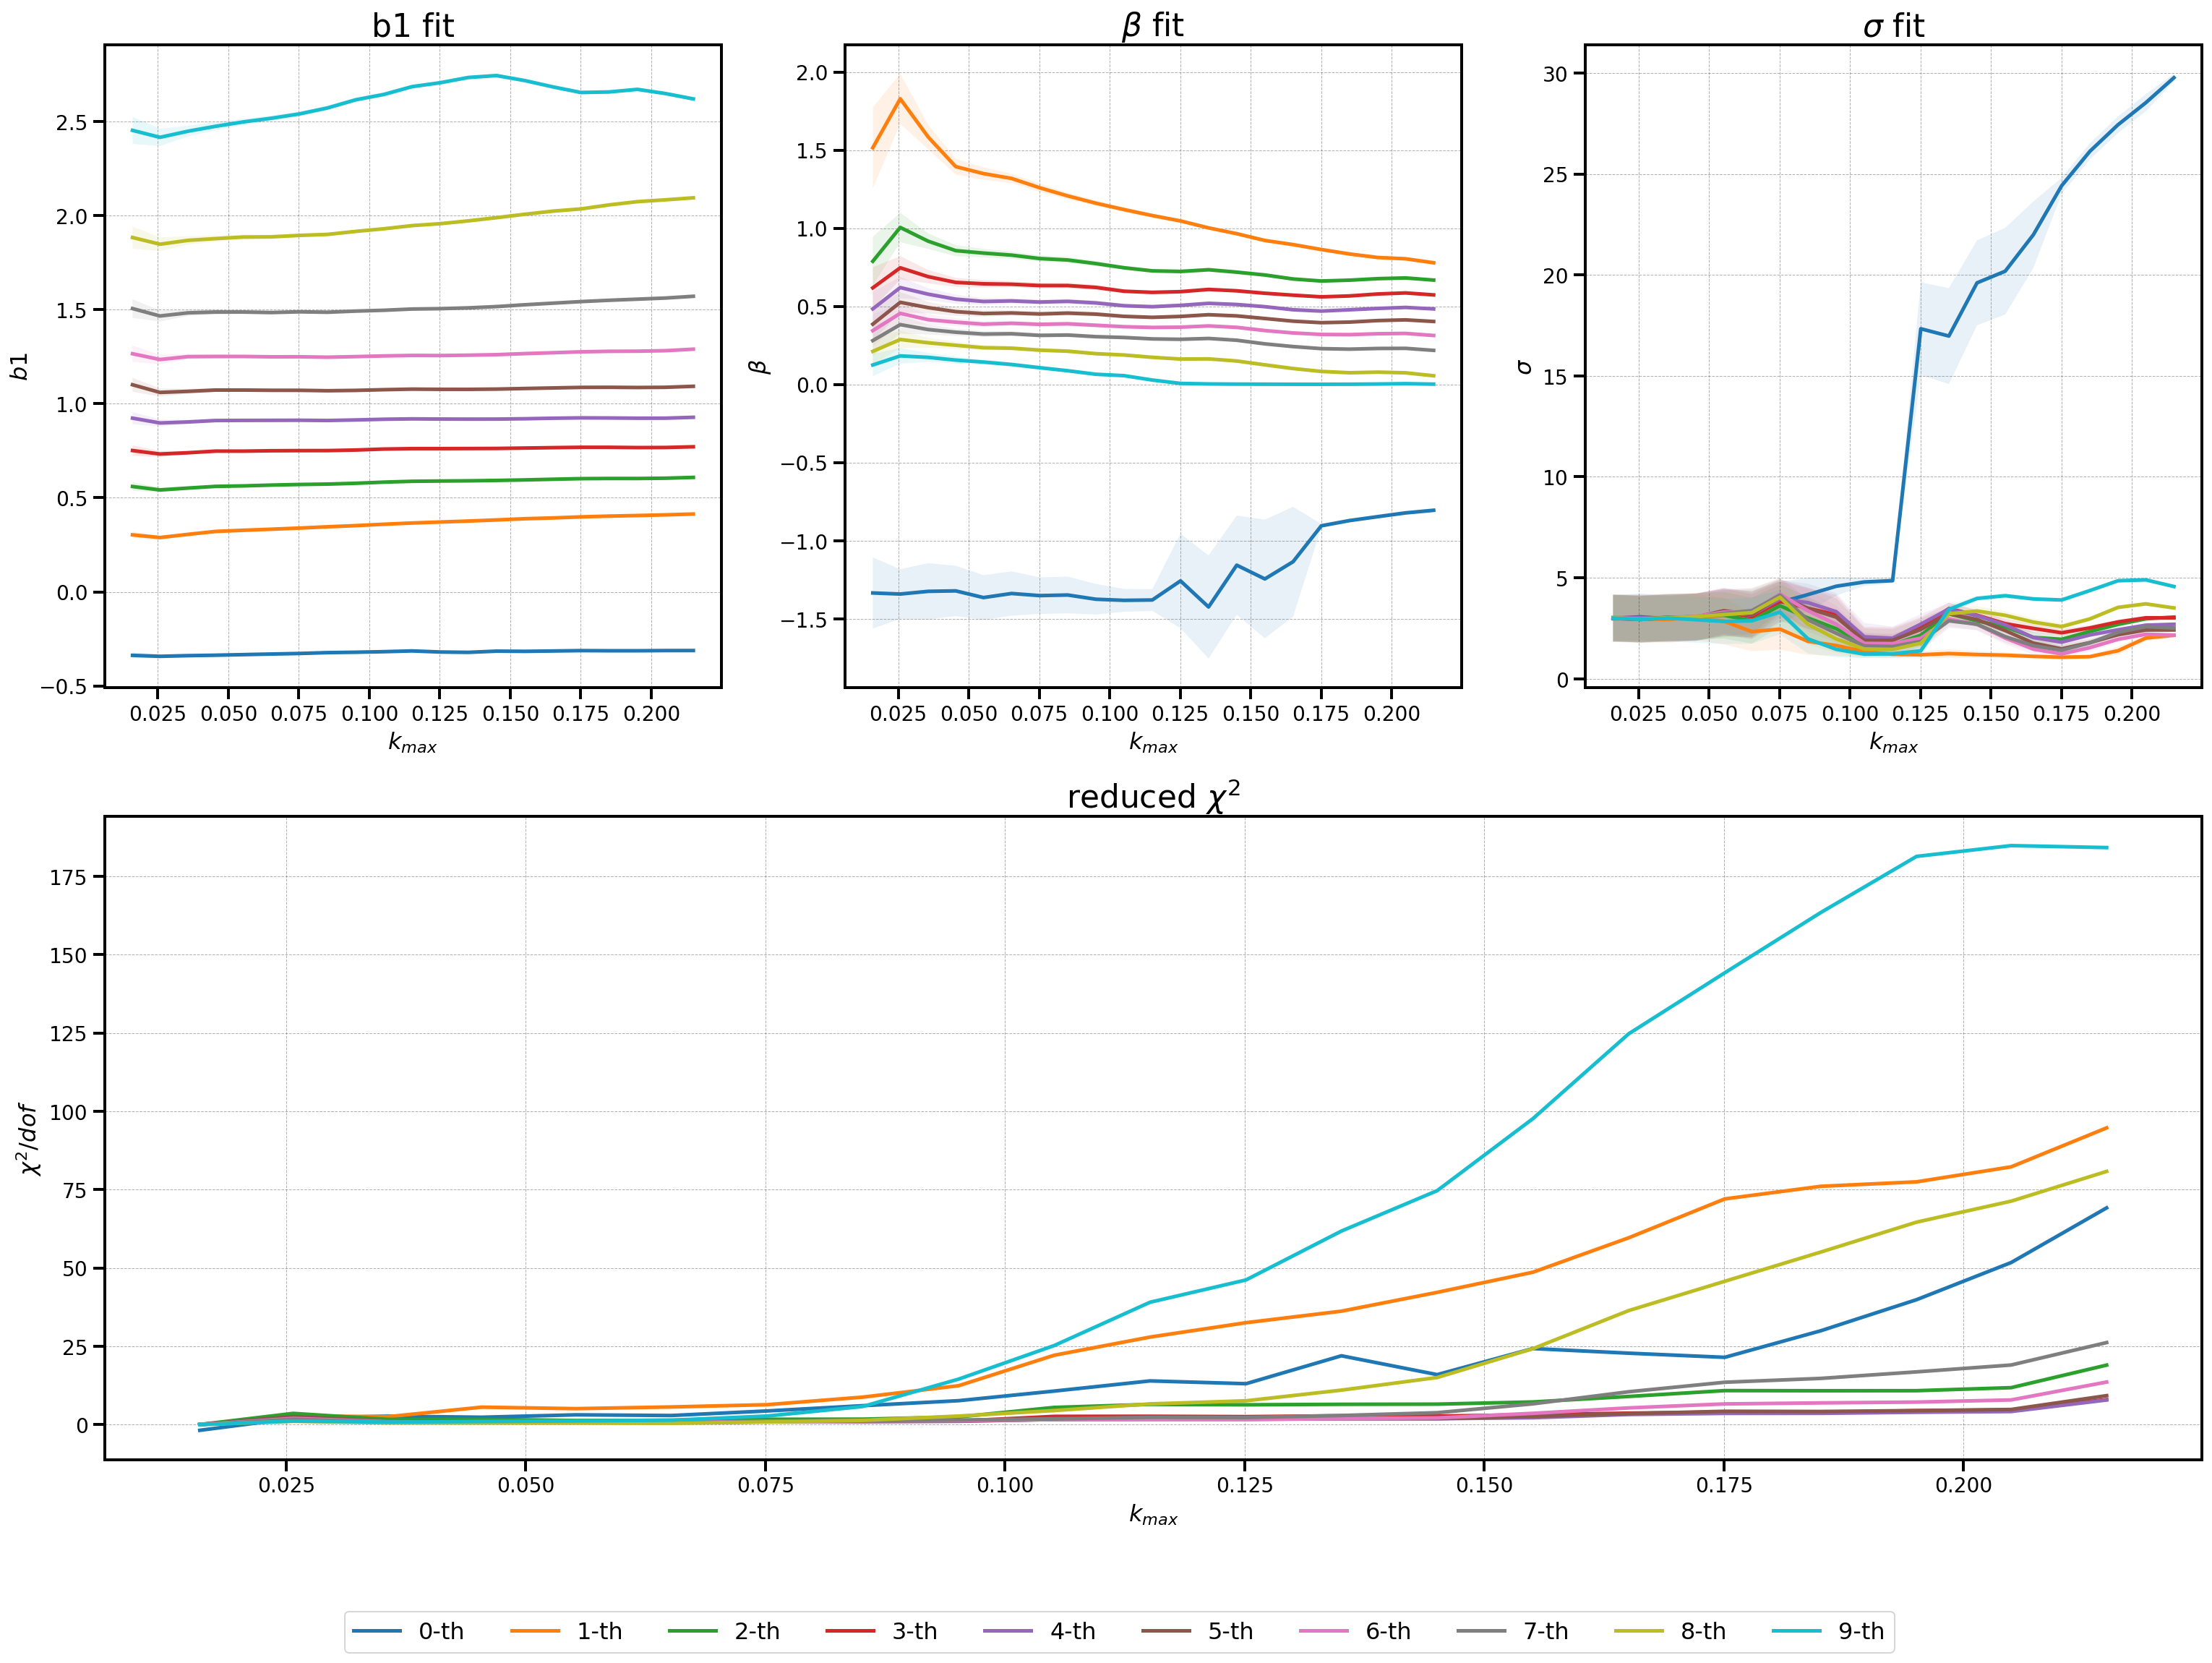

In [15]:
fig = plt.figure(figsize=(26,18))

ax_b1 = plt.subplot(2,3,1)
ax_beta = plt.subplot(2,3,2)
ax_sigma = plt.subplot(2,3,3)
ax_chi2 = plt.subplot(2,3,(4,6))

for i in range(n_ptile):
    ax_b1.plot(kmax_range, b1_fits[i], label='%d-th'%i)
    ax_b1.fill_between(kmax_range, b1_fits[i]-b1_stds[i], b1_fits[i]+b1_stds[i], alpha=0.1)
    
    ax_beta.plot(kmax_range, beta_fits[i], label='%d-th'%i)
    ax_beta.fill_between(kmax_range, beta_fits[i]-beta_stds[i], beta_fits[i]+beta_stds[i], alpha=0.1)
    
    ax_sigma.plot(kmax_range, sigma_fits[i], label='%d-th'%i)
    ax_sigma.fill_between(kmax_range, sigma_fits[i]-sigma_stds[i], sigma_fits[i]+sigma_stds[i], alpha=0.1)
    
    ax_chi2.plot(kmax_range, reduced_chi2[i], label='%d-th'%i)
  
ax_b1.set_title('b1 fit')
ax_b1.set_xlabel(r'$k_{max}$')
ax_b1.set_ylabel(r'$b1$')

ax_beta.set_title(r'$\beta$ fit')
ax_beta.set_xlabel(r'$k_{max}$')
ax_beta.set_ylabel(r'$\beta$')

ax_sigma.set_title(r'$\sigma$ fit')
ax_sigma.set_xlabel(r'$k_{max}$')
ax_sigma.set_ylabel(r'$\sigma$')

ax_chi2.set_title(r'reduced $\chi^2$')
ax_chi2.set_xlabel(r'$k_{max}$')
ax_chi2.set_ylabel(r'$\chi^2 / dof$')

handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, +0.05), ncol=n_ptile)

plt.show()
fig.savefig("plots/Kaiserdamped_largesig_fits.pdf")

### Interpretation
Upon comparing this plot to the one produced by `pre-analysis_fit.ipynb` (`parameter_guesses.pdf`) (using fast minimization of chi2 to estimate mean of parameters), we find good agreement in the plots of $b_1$ and $\beta$. Note that in the analysis, to produce fs8$>0$, we had to invert the sign of $b_1$ for the 0th density bin after fitting (model is symmetric in sign of $b_1$). This causes an apparent difference to `parameter_guesses.pdf` where the guessed value of $b_1$ is positive.

As expected, the simple model only works up to small $k_{max}$, illustrated by growing reduced $\chi^2$.  

Note that the FoG term is of form $\exp(-0.5(\sigma k \mu)^2)$ and corrects the Kaiser model by damping it which only occurs for large $k$. For small $k_{max}$ the damping term is approximately 1 for all $\sigma$, such that the data cannot inform the value of $\sigma$. This causes the $\sigma$ posterior to be approximately the same as the prior. Since we choose `Uniform(1,5)` as the prior, the above $\sigma$ plot is centered on $\sigma=\frac{5-1}{2}$ with a standard deviation of $\sqrt{\frac{(5-1)^2}{12}} = \frac{2}{\sqrt{3}} \approx 1.15$.
Only for $k_{max}>0.1$ it appears that $\sigma$ can be fitted. Note that the 0th density bin actually reaches the top end of the prior for $k_{max}>0.125$. In `pre-analysis_fit.ipynb` found that for this bin $\sigma$ increases sharply at $k_{max} = 0.125$ and reaches 30 at $k_{max} = 0.2$.

In [ ]:
chain = chains[0][2]

In [ ]:
plt.figure(figsize=(16,1.5*ndim))
labels = [r'$b1$', r'$\beta$', r'$\sigma$']
for n in range(ndim):
    plt.subplot2grid((ndim, 1), (n, 0))
    plt.plot(chain[:,n], alpha=0.5)
    plt.ylabel(labels[n])
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = zeus.cornerplot(chain.reshape((-1,ndim), order='F'), labels=[r'$b1$', r'$\beta$', r'$\sigma$']);